In [19]:
import sys
import os

# So we can still import from your repo if needed
project_path = r"C:\Users\jjmcc\OneDrive\Documents\Thesis Interim\ITGC-interim"
if project_path not in sys.path:
    sys.path.append(project_path)

print("Project path added:", project_path)

import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import open_clip  # CLIP implementation


Project path added: C:\Users\jjmcc\OneDrive\Documents\Thesis Interim\ITGC-interim


In [20]:
# Where all processed PNG slices live
DATA_ROOT = r"E:/ProcessedMRI"

key_to_path = {}

for root, dirs, files in os.walk(DATA_ROOT):
    for f in files:
        if f.endswith(".png"):
            key_to_path[f] = os.path.join(root, f)

print("Mapped PNG files:", len(key_to_path))

# Create deterministic lists of keys and paths
keys = sorted(key_to_path.keys())
paths = [key_to_path[k] for k in keys]

print("First 5 keys:", keys[:5])
print("First 5 paths:", paths[:5])


Mapped PNG files: 40
First 5 keys: ['slice_00_ED.png', 'slice_00_ES.png', 'slice_01_ED.png', 'slice_01_ES.png', 'slice_02_ED.png']
First 5 paths: ['E:/ProcessedMRI\\L8M2U8\\slice_00_ED.png', 'E:/ProcessedMRI\\L8M2U8\\slice_00_ES.png', 'E:/ProcessedMRI\\L8M2U8\\slice_01_ED.png', 'E:/ProcessedMRI\\L8M2U8\\slice_01_ES.png', 'E:/ProcessedMRI\\L8M2U8\\slice_02_ED.png']


In [21]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# Light CLIP model from open_clip
model, _, preprocess = open_clip.create_model_and_transforms(
    "ViT-B-32", pretrained="laion2b_s34b_b79k"
)
model = model.to(device)
model.eval()

print("CLIP model loaded.")


Using device: cpu


d:\Users\jjmcc\anaconda3\envs\ITGC-interim\lib\site-packages\huggingface_hub\file_download.py:121: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\jjmcc\.cache\huggingface\hub\models--laion--CLIP-ViT-B-32-laion2B-s34B-b79K. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


CLIP model loaded.


In [22]:
from tqdm import tqdm

emb_dim = model.visual.output_dim  # embedding dimension (usually 512)
N = len(paths)
img_embeds = np.zeros((N, emb_dim), dtype=np.float32)

BATCH_SIZE = 32

with torch.no_grad():
    for start in tqdm(range(0, N, BATCH_SIZE), desc="Encoding images"):
        end = min(start + BATCH_SIZE, N)
        batch_paths = paths[start:end]

        images = []
        for p in batch_paths:
            img = Image.open(p).convert("RGB")
            images.append(preprocess(img))

        batch_tensor = torch.stack(images).to(device)
        feats = model.encode_image(batch_tensor)
        # L2-normalize
        feats = feats / feats.norm(dim=-1, keepdim=True)

        img_embeds[start:end] = feats.cpu().numpy()

print("Image embeddings shape:", img_embeds.shape)


Encoding images: 100%|██████████| 2/2 [00:06<00:00,  3.29s/it]

Image embeddings shape: (40, 512)


In [23]:
prompts = [
    "short axis cardiac MRI slice",
    "long axis cardiac MRI slice",
    "end-diastolic frame of the heart",
    "end-systolic frame of the heart",
    "apical slice of the left ventricle",
    "basal slice of the left ventricle",
    "mid-ventricular slice of the left ventricle",
]

print("Number of prompts:", len(prompts))

tokenizer = open_clip.get_tokenizer("ViT-B-32")

with torch.no_grad():
    text_tokens = tokenizer(prompts).to(device)
    text_feats = model.encode_text(text_tokens)
    text_feats = text_feats / text_feats.norm(dim=-1, keepdim=True)

text_embeds = text_feats.cpu().numpy()
print("Text embeddings shape:", text_embeds.shape)


Number of prompts: 7
Text embeddings shape: (7, 512)


In [24]:
# Cosine similarity since both are normalized
similarity = img_embeds @ text_embeds.T  # shape: (N_images, N_prompts)
print("Similarity matrix shape:", similarity.shape)

# This is our feature matrix for clustering
X = similarity.copy()


Similarity matrix shape: (40, 7)


In [25]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Optional: PCA to 2D for plotting
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
print("PCA projection shape:", X_pca.shape)



PCA projection shape: (40, 2)


In [26]:
n_clusters = 5  # same as before

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters_text_guided = kmeans.fit_predict(X_scaled)

print("Cluster assignments shape:", clusters_text_guided.shape)
print("Cluster counts:", np.bincount(clusters_text_guided))


Cluster assignments shape: (40,)
Cluster counts: [14  4  6 10  6]


d:\Users\jjmcc\anaconda3\envs\ITGC-interim\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


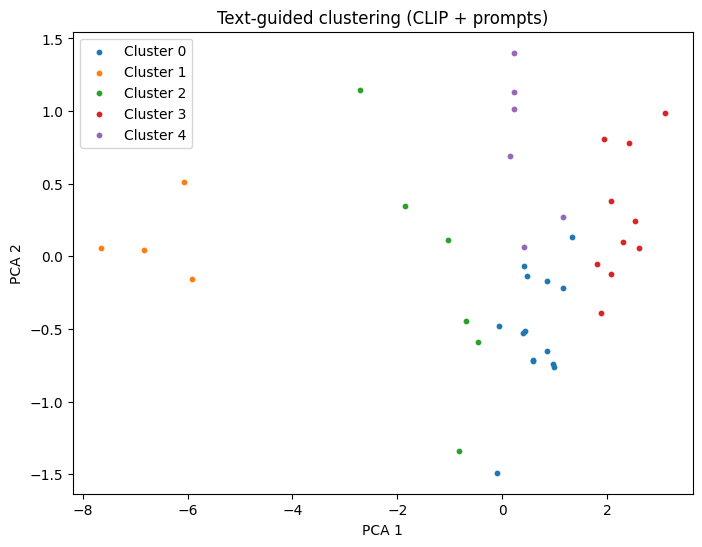

In [27]:
plt.figure(figsize=(8, 6))
for c in range(n_clusters):
    idx = clusters_text_guided == c
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], s=10, label=f"Cluster {c}")

plt.title("Text-guided clustering (CLIP + prompts)")
plt.legend()
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()


In [28]:
cluster_contents_text = {c: [] for c in range(n_clusters)}

for key, cid in zip(keys, clusters_text_guided):
    cluster_contents_text[cid].append(key)

for c in range(n_clusters):
    print(f"Cluster {c}: {len(cluster_contents_text[c])} images")


Cluster 0: 14 images
Cluster 1: 4 images
Cluster 2: 6 images
Cluster 3: 10 images
Cluster 4: 6 images



=== Text-guided Cluster 0 ===


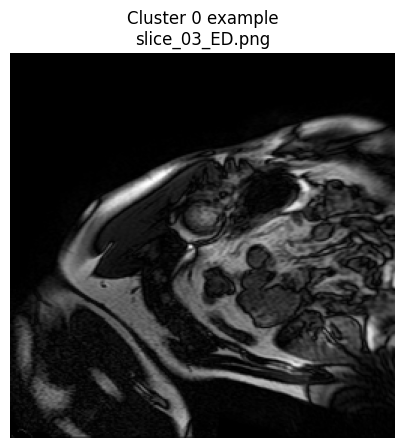

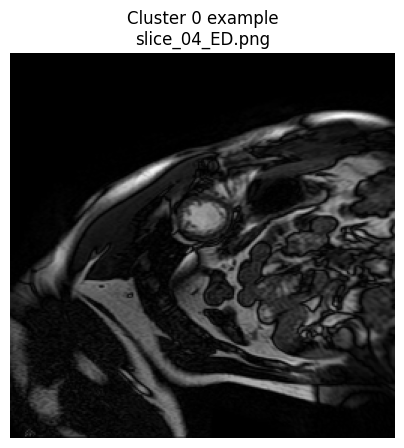


=== Text-guided Cluster 1 ===


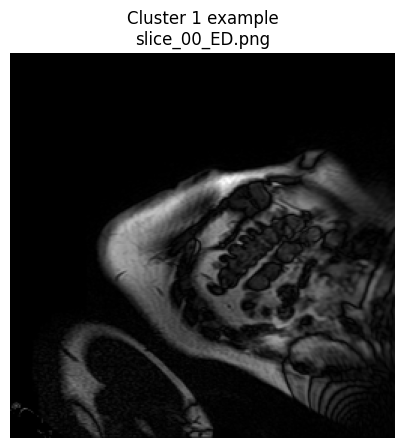

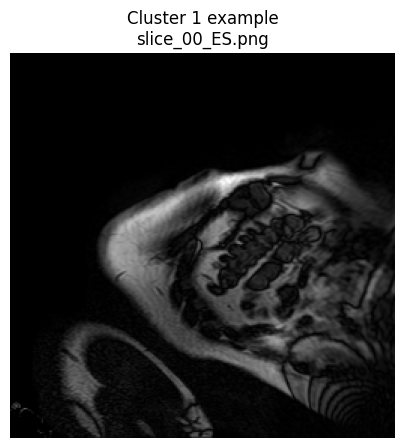


=== Text-guided Cluster 2 ===


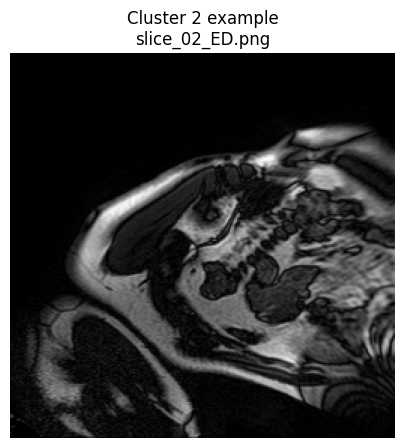

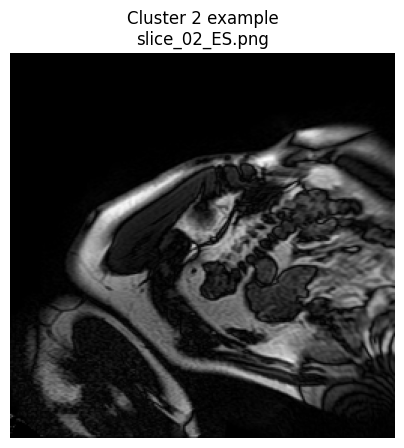


=== Text-guided Cluster 3 ===


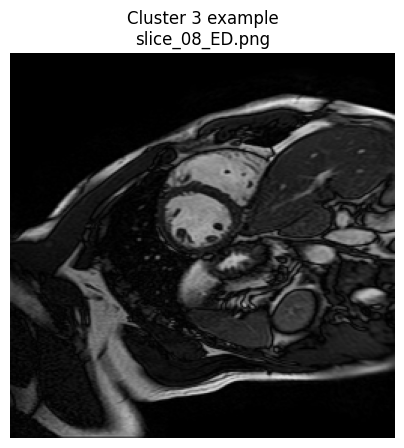

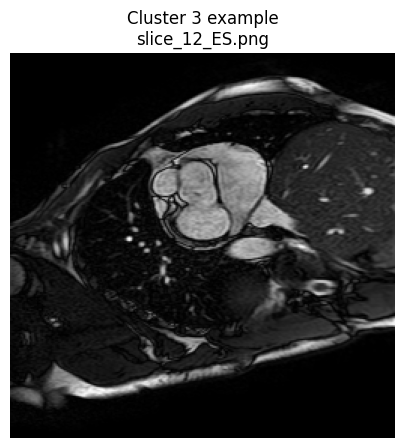


=== Text-guided Cluster 4 ===


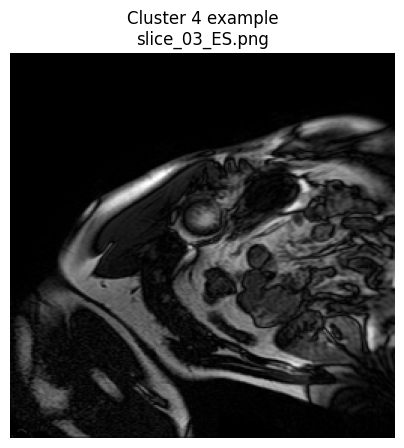

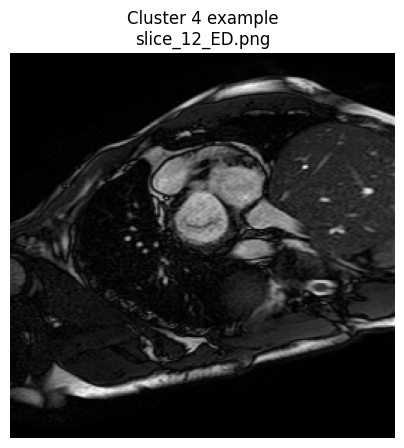

In [29]:
import cv2

def show_text_guided_example(c, n_examples=3):
    print(f"\n=== Text-guided Cluster {c} ===")
    cluster_keys = cluster_contents_text[c]
    if not cluster_keys:
        print("No images in this cluster.")
        return

    for key in cluster_keys[:n_examples]:
        path = key_to_path.get(key, None)
        if path is None:
            print(f"⚠️ Path not found for key: {key}")
            continue

        img = cv2.imread(path)
        if img is None:
            print(f"⚠️ Could not load image at {path}")
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(5, 5))
        plt.imshow(img)
        plt.title(f"Cluster {c} example\n{key}")
        plt.axis("off")
        plt.show()

for c in range(n_clusters):
    show_text_guided_example(c, n_examples=2)


In [32]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

def evaluate_clustering(X_features, labels):
    print("=== Clustering Quality Metrics ===")
    
    sil = silhouette_score(X_features, labels)
    print(f"Silhouette Score:           {sil:.4f}")


    return sil

    


In [33]:
print("TEXT-GUIDED CLUSTERING METRICS:")
evaluate_clustering(X_scaled, clusters_text_guided)


TEXT-GUIDED CLUSTERING METRICS:
=== Clustering Quality Metrics ===
Silhouette Score:           0.3835


0.3834688663482666